In [1]:
""" 
This notebook contains the simulations, figures and results 
presented in Chapter 5 of the master's thesis.

In the notebook NN-Classifier-for-hardcoded-policy there is all the code used
initially.

Author: Daniel Salgado Rojo
"""
import tensorflow as tf
import numpy as np
import gym
import gym_pdsystem
from gym import wrappers
import argparse
import pprint as pp

from datetime import datetime

import random
from gym_pdsystem.envs.pdsystem_env import PDSystemEnv

import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct


from matplotlib import animation, rc
import matplotlib.pyplot as plt
from IPython.display import HTML

import os
from pathlib import Path
import time 
import pandas as pd


from sklearn.preprocessing import StandardScaler
    
#TO OMMIT WARNINGS
import warnings
warnings.filterwarnings('ignore')

/home/dsalgador/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# The leftmost-emptiest-tank policy ($\pi_m$)

In [2]:
# Hard-coded policy

def leftmost_emptiest_tank_policy(s, system):
    """
    It is assumed a system with only one Truck (k=1)
    
    Given a PDSystem and its state 's' this (deterministic function) returns
    the tank with minimum load (in case of ties, the leftmost), unless the total load of the truck does not fit
    in that tank (in which case the number of tanks is returned, which stands for staying at the depot).
    Note that if the load of the truck does not fit in the tank with minimum load, it will fit even less
    in the others.
    """
    min_boolean_indexes = np.isin(s, np.min(s))
    min_indexes = np.where(min_boolean_indexes)
    min_indexes = min_indexes[0]

    possible_indexes = []
    
    for tank_visited in min_indexes:
        hypothetical_next_tank_state = s[tank_visited] + system.truck_max_loads
        if hypothetical_next_tank_state <= system.tank_max_loads[tank_visited]:
                    possible_indexes.append(tank_visited)
    
    
    if len(possible_indexes) != 0:
        tank_to_go = possible_indexes[0] # THIS IS WHAT CHANGES WITH RESPECT TO THE emptiest_tank_policy()
        return tank_to_go
    else:
        return system.n #stay in the depot

# Creating train, validation and test sets

In [24]:
data_directory = './data'
figures_directory = './figures'
if not os.path.exists(data_directory):
    os.makedirs(data_directory)
if not os.path.exists(figures_directory):
    os.makedirs(figures_directory)    

In [4]:
################################################################################
# Example k = 1 (trucks), n = 3 (tanks)
################################################################################

# Variables to initialize a gym-pdsystem environment
# ENSURE THAT THE FOLLOWING VARIABLES COINCIDES WITH THE CASE k=1 n=3 in the constants.py file
# AND ALSO THAT CASE = -1 (or other negative number)

TANK_MAX_LOADS = np.array([100., 200, 100.])
LEVEL_PERCENTAGES = np.array([ #b , c, e
                                                [0.02, 0.31, 0.9],
                                                [0.01, 0.03, 0.9],
                                                [0.05, 0.16, 0.9]
                                                   ])
TRUCK_MAX_LOADS = np.array([50.])
GRAPH_WEIGHTS = np.array([32., 159., 162., 0.]) #useless in the current notbook

DISCRETE = True
################################################################################

boolean = (not np.array_equal(TANK_MAX_LOADS, ct.TANK_MAX_LOADS) ) or  (not np.array_equal(LEVEL_PERCENTAGES,ct.LEVEL_PERCENTAGES)) 
boolean = boolean or ( not np.array_equal(TRUCK_MAX_LOADS, ct.TRUCK_MAX_LOADS))
boolean = boolean or  (not np.array_equal(GRAPH_WEIGHTS, ct.GRAPH_WEIGHTS))
boolean = boolean or not (DISCRETE == ct.DISCRETE)
if boolean:
    raise Exception("ENSURE THAT THE VARIABLES ABOVE COINCIDE WITH THE CASE k=1 n=3 in the constants.py file")

In [5]:
# Environment initialization and random seeds for reproducibility
episode_length = 30
seed = 42

system = PDSystemEnv(tank_max_loads = TANK_MAX_LOADS, level_percentages = LEVEL_PERCENTAGES,
                     truck_max_loads = TRUCK_MAX_LOADS, graph_weights = GRAPH_WEIGHTS,  
                     discrete = DISCRETE)

env = gym.make("PDSystemEnv-v0")
env._max_episode_steps = episode_length

np.random.seed(seed)
tf.set_random_seed(seed)
env.seed(seed)

# Sizes for the train, validation and test data. And filenames to save them.
N_TRAIN = 10**4; SEED_TRAIN = 42; train_file = './data/train.txt'
N_VAL = 10**3; SEED_VAL = 50; validation_file = './data/validation.txt'
N_TEST = 10**3; SEED_TEST = 58; test_file = './data/test.txt'

# Number of decimals to round the outputted data
round_decimals = 5

# Set to True only when wanting to create the datasets.
CREATE_DATASETS = False

def create_datasets(outputfile, n_observations, seed = None, round_decimals = round_decimals): 
    """
    Creates train, validation and test sets for multiclass classification, initializing
    each of the tanks of the gym-pdsystem uniformly. Each observation consists in the initial levels 
    of each tank (x) and the action that the truck should do according to the leftmost-emptiest-tank policy
    (the target y).
    """
    if seed != None:
        np.random.seed(seed)
        
    with open('{}'.format(outputfile),'w') as f:
        np.savetxt(f, [np.array(['tank1', 'tank2', 'tank3', 'target'])], fmt = "%s", delimiter=',')
        print("Creating {} file...".format(outputfile))
        for i in range(n_observations):
            if i % (int(n_observations / 100)) == 0:
                p = round(i/n_observations *100,1)
                print("\rPercentage: {} %".format(p), end="")
            obs = []
            for max_load in TANK_MAX_LOADS:
                random_load = np.random.random() * max_load
                obs.append(np.round(random_load,round_decimals)  )

            obs.append(leftmost_emptiest_tank_policy(np.array(obs), system))   
            np.savetxt(f, [np.array(obs)], fmt = ('%f','%f', '%f', '%d'), delimiter=',')  #!! fmt only for n=3
    print("\rCreated {} file.".format(outputfile))
    
if CREATE_DATASETS:          
    create_datasets(train_file, N_TRAIN, SEED_TRAIN) 
    create_datasets(validation_file, N_VAL, SEED_VAL)      
    create_datasets(test_file, N_TEST, SEED_TEST)            

In [6]:
train = pd.read_table(train_file, sep = ",")
test = pd.read_table(test_file, sep = ",")
validation = pd.read_table(validation_file, sep = ",")

# Exploring the train dataset

As expected the load of the tanks is initialized with a uniform distribution between 0 and the maximum
load capacity of each tank.

Note that the dataset is not balanced in terms of the target values, since we have about two times of observations
for when the targets are tank 0 and tank 2, compared to tank 1 and ``staying at the depot'' (y=3).

The fact that tank 1 appears as target about half the times it does with tanks 0 and 2 is intuitively explained by the fact that tank 1 has de double of maximum capacity than the other two so the probability of being the tank with minium load is half the probability that the other two tanks were the ones with the minimum.

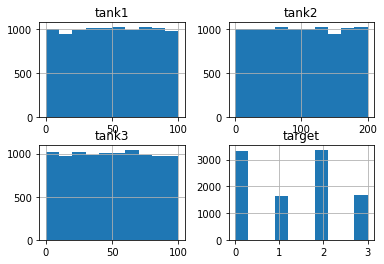

In [7]:
train.hist()
plt.show()

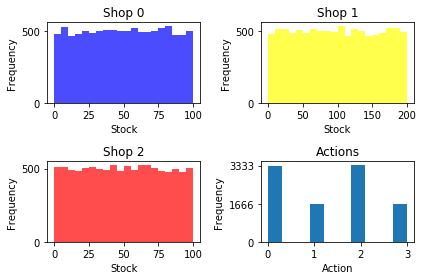

In [8]:
shops = [train['tank1'], train['tank2'], train['tank3']]
actions = train['target']

colors = ["Blue", "Yellow", "Red", "Black"]

bins = 20
for i in range(1,len(shops)+1):
    plt.subplot(2,2, i)    
    plt.hist([shops[i-1]], color = colors[i-1], alpha = 0.7, bins = bins)
    plt.yticks([0, int(N_TRAIN/bins)])
    plt.xlabel("Stock")
    plt.ylabel("Frequency")
    plt.title('Shop {}'.format(i-1))

# Actions' histogram 
plt.subplot(2,2, 4)    
plt.hist([actions])
#hist = np.histogram([actions])
#print(hist)
plt.yticks([0, int(N_TRAIN/6), int(N_TRAIN/3)])
plt.title('Actions')
plt.xlabel("Action")
plt.ylabel("Frequency")
 
plt.tight_layout() 
plt.show()
plt.savefig(figures_directory +'/train-data-histograms' + '.pdf')
plt.close()

In [9]:
# Print the daily consumption rates of each tank
print(system.tank_consumption_rates)

[16.5  4.  10.5]


## Prepare data for feeding it to different classifiers

In [10]:
y_train = train["target"].values#.reshape((N_TRAIN, ))
X_train = train[["tank1", "tank2","tank3"]].values

y_test = test["target"].values#.reshape((N_TEST, ))
X_test = test[["tank1", "tank2","tank3"]].values

y_val = validation["target"]#.reshape((N_VAL, ))
X_val = validation[["tank1", "tank2","tank3"]].values

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

# Neural Network Classifier

In [11]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
# Create a simulations' directory
sim_directory = './simulations'
if not os.path.exists(sim_directory):
    os.makedirs(sim_directory)

## Deep Neural Network model

In [12]:
SIMULATION = 3

# Simulation parameters
simulation_directory = './simulations/simulation{}'.format(SIMULATION)
if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
else:
    raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")
    
model_file = simulation_directory + '/final_nn_classifier_sim{}.ckpt'.format(SIMULATION)
graph_file =  '{}.meta'.format(model_file)  

# File to output performance metrics during training
training_file = simulation_directory+'/training-metrics.csv'.format(SIMULATION)

test_file = simulation_directory+'/testing-states.csv'.format(SIMULATION)

In [13]:
reset_graph()

seed = 42
learning_rate = 0.01 #0.01

epochs = 1000 
batch_size = 50 #50

summary_freq = 1#np.ceil(epochs/10) #200
output_freq = 10*summary_freq #np.ceil(epochs/10) #200


hidden1_neurons = 4 #100
hidden2_neurons = 4 #50

scaling = False

regularization = False
beta = 0.01

if scaling:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.astype(np.float64))
    X_val = scaler.fit_transform(X_val.astype(np.float64))
    X_test = scaler.fit_transform(X_test.astype(np.float64))
    model_file = simulation_directory + '/final_nn_classifier_scaled_sim{}.ckpt'.format(SIMULATION)

tf.set_random_seed(seed)

with tf.name_scope("dnn"):
            # 1. Parameters to determine the NN architecture

            n_inputs = env.observation_space.shape[1]
            n_hidden1 = hidden1_neurons; activation1 = tf.nn.elu
            n_hidden2 = hidden2_neurons; activation2 = tf.nn.elu
            n_outputs = env.action_space.shape[1]

            initializer = tf.contrib.layers.variance_scaling_initializer()
            
            # Regularization of weights
            if regularization:
                regularizer = tf.contrib.layers.l2_regularizer(scale = beta)
            else:
                regularizer = None
            # 2. Build the Neural Network
            
            X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
            y = tf.placeholder(tf.int64, shape = (None), name = "y")
            
            hidden1 = tf.layers.dense(X, n_hidden1, activation = activation1,
                                     kernel_initializer = initializer,
                                     kernel_regularizer = regularizer)
            hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = activation2,
                                     kernel_initializer = initializer,
                                     kernel_regularizer = regularizer)
            logits = tf.layers.dense(hidden2, n_outputs,kernel_initializer = initializer,
                                    kernel_regularizer = regularizer)
            
with tf.name_scope("loss"):
            
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,
                                                                      logits = logits)
            loss = tf.reduce_mean(xentropy, name = "loss")
            
#             if regularization:
#                 reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#                 loss = loss +  sum(reg_losses) # * beta
       
tf.summary.scalar('average_cross_entropy', loss)
            
with tf.name_scope("train"):
            # Optimization Op
            optimizer = tf.train.AdamOptimizer(learning_rate)
            optimize = optimizer.minimize(loss)
            
with tf.name_scope("eval"):
            # Accuracy
            correct = tf.nn.in_top_k(logits, y, 1)
            accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
tf.summary.scalar('accuracy', accuracy)

            
with tf.name_scope("action"):
            outputs = tf.nn.softmax(logits)
            # 3. Select a random action (where to go) based on the estimated probabilities
            action = tf.multinomial(tf.log(outputs), num_samples = 1)
with tf.name_scope("confusion-matrix"):
            # Confusion matrix
            conf_mx = tf.confusion_matrix(labels=y, predictions=action)
            
merged = tf.summary.merge_all()
init = tf.global_variables_initializer()
        
if model_file != None:
            saver = tf.train.Saver()
        

def fetch_batch(X,y,epoch, batch_index, batch_size, data_size, n_batches):
        np.random.seed(epoch * n_batches + batch_index)  
        indices = np.random.randint(data_size, size=batch_size)  
        X_batch = X[indices] 
        y_batch = y[indices] 
        return X_batch, y_batch

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = sim_directory +"/tf_logs"
log_dir = "{}/run-{}-sim{}/".format(root_logdir, now, SIMULATION)


Instructions for updating:
Use the retry module or similar alternatives.


## Training

In [14]:
round_time = 2
    
best_acc_val = 0
acc_val = 0

# Output headers to file
with open(training_file,'w') as f:
     np.savetxt(f, [["epoch", "acc_train", "acc_val", "best_acc_val"]], fmt="%s", delimiter=',')    

with tf.Session() as sess:
        time_start = time.time()
        
        train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
        val_writer = tf.summary.FileWriter(log_dir + '/val')
        
        init.run()
        N_TRAIN = X_train.shape[0]
        m = y_train.shape[0]
        
        n_batches = int(np.ceil(N_TRAIN/ batch_size))
             
        for epoch in range(epochs+1):
            print("\rEpoch: {}".format(epoch), end="")            
            for batch_index in range(n_batches):
                X_batch, y_batch = fetch_batch(X_train,y_train,epoch, batch_index, batch_size, m, n_batches)
                sess.run(optimize, feed_dict={
                                    y: y_batch,
                                    X: X_batch
                                })
            
            # Summaries, runtime outputs and data to files.
            if summary_freq != None: 
                            
                if epoch % summary_freq  == 0:
                    

                    summary, acc_train = sess.run([merged, accuracy], feed_dict={
                                        y: y_batch,
                                        X: X_batch
                                    })
                    train_writer.add_summary(summary, epoch)

                    summary, acc_val = sess.run([merged, accuracy], feed_dict={
                                        y: y_val,
                                        X: X_val
                                    }) 
                                    
                    val_writer.add_summary(summary, epoch)
                    
                    time_end = time.time()
                    if epoch % output_freq  == 0:
                        print(". Batch accuracy: ", acc_train, 
                              " Val. accuracy: ", acc_val,
                             " Best Val. accuracy: ", best_acc_val,
                             " Elapsed time: ", round( (time_end-time_start)/60., round_time), " min.")
                    if best_acc_val < acc_val:                        
                        save_path = saver.save(sess, model_file)
                        #print(". Saved model with validation accuracy ", acc_val)
                        
                    best_acc_val = max(best_acc_val, acc_val)
                    
                    # Output data to files
                    with open(training_file,'ab') as f:
                         np.savetxt(f, [np.array([epoch, acc_train, acc_val, best_acc_val])], fmt='%.6f', delimiter=',')    
        
        train_writer.close()
        val_writer.close()
        time_end = time.time()
        print("\rElapsed time: ", round( (time_end-time_start)/60., round_time), " minutes.", " Best Validation accuracy: ", best_acc_val)
        #save_path = saver.save(sess, model_file)   

Epoch: 0. Batch accuracy:  0.86  Val. accuracy:  0.776  Best Val. accuracy:  0  Elapsed time:  0.0  min.
Epoch: 10. Batch accuracy:  0.92  Val. accuracy:  0.938  Best Val. accuracy:  0.925  Elapsed time:  0.02  min.
Epoch: 20. Batch accuracy:  0.92  Val. accuracy:  0.948  Best Val. accuracy:  0.953  Elapsed time:  0.03  min.
Epoch: 30. Batch accuracy:  0.98  Val. accuracy:  0.944  Best Val. accuracy:  0.969  Elapsed time:  0.04  min.
Epoch: 40. Batch accuracy:  0.94  Val. accuracy:  0.972  Best Val. accuracy:  0.977  Elapsed time:  0.05  min.
Epoch: 50. Batch accuracy:  1.0  Val. accuracy:  0.972  Best Val. accuracy:  0.977  Elapsed time:  0.06  min.
Epoch: 60. Batch accuracy:  0.98  Val. accuracy:  0.964  Best Val. accuracy:  0.977  Elapsed time:  0.07  min.
Epoch: 70. Batch accuracy:  0.98  Val. accuracy:  0.97  Best Val. accuracy:  0.977  Elapsed time:  0.09  min.
Epoch: 80. Batch accuracy:  1.0  Val. accuracy:  0.976  Best Val. accuracy:  0.982  Elapsed time:  0.1  min.
Epoch: 90. 

Epoch: 740. Batch accuracy:  0.96  Val. accuracy:  0.959  Best Val. accuracy:  0.991  Elapsed time:  0.93  min.
Epoch: 750. Batch accuracy:  0.98  Val. accuracy:  0.969  Best Val. accuracy:  0.991  Elapsed time:  0.94  min.
Epoch: 760. Batch accuracy:  0.98  Val. accuracy:  0.958  Best Val. accuracy:  0.991  Elapsed time:  0.95  min.
Epoch: 770. Batch accuracy:  0.98  Val. accuracy:  0.96  Best Val. accuracy:  0.991  Elapsed time:  0.97  min.
Epoch: 780. Batch accuracy:  1.0  Val. accuracy:  0.96  Best Val. accuracy:  0.991  Elapsed time:  0.98  min.
Epoch: 790. Batch accuracy:  1.0  Val. accuracy:  0.982  Best Val. accuracy:  0.991  Elapsed time:  0.99  min.
Epoch: 800. Batch accuracy:  0.98  Val. accuracy:  0.972  Best Val. accuracy:  0.991  Elapsed time:  1.01  min.
Epoch: 810. Batch accuracy:  1.0  Val. accuracy:  0.972  Best Val. accuracy:  0.991  Elapsed time:  1.02  min.
Epoch: 820. Batch accuracy:  0.96  Val. accuracy:  0.962  Best Val. accuracy:  0.991  Elapsed time:  1.03  mi

### Visualizing training performance

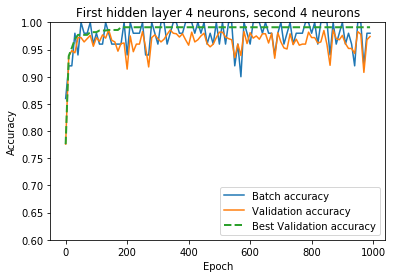

In [15]:
metrics = pd.read_table(training_file, sep = ",")
metrics.head()

def plot_accuracy(metrics):
    indices = [i for i in range(0,1000,10)]
    plt.plot(metrics['epoch'][indices],metrics['acc_train'][indices], label = "Batch accuracy")
    plt.plot(metrics['epoch'][indices],metrics['acc_val'][indices], label = "Validation accuracy")
    plt.plot(metrics['epoch'][indices],metrics['best_acc_val'][indices], label = "Best Validation accuracy",linestyle = '--',linewidth = 2.0)

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='lower right')
    plt.ylim(.6,1.0)
    
plot_accuracy(metrics) 
plt.title("First hidden layer {} neurons, second {} neurons".format(n_hidden1, n_hidden2))

plt.show()
plt.close()

### Training performance for simulations shown in the thesis

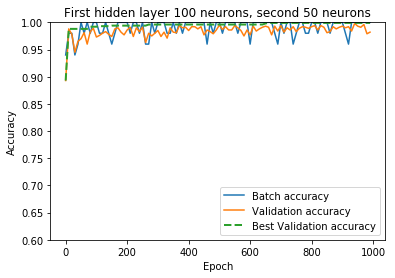

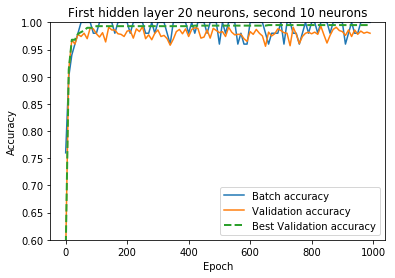

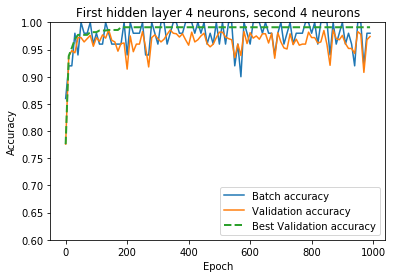

In [25]:
# Visualize simulations
SIMULATION = 1
# Simulation parameters
simulation_directory = './simulations/simulation{}'.format(SIMULATION)
# File to output performance metrics during training
training_file = simulation_directory+'/training-metrics.csv'.format(SIMULATION)
metrics = pd.read_table(training_file, sep = ",")
#plt.subplot(211)
plot_accuracy(metrics)
plt.title("First hidden layer 100 neurons, second 50 neurons")
plt.savefig(figures_directory +'/training-metrics-'+ 'sim{}'.format(SIMULATION) + '.pdf')
plt.show()
plt.close()



SIMULATION = 2
# Simulation parameters
simulation_directory = './simulations/simulation{}'.format(SIMULATION)
# File to output performance metrics during training
training_file = simulation_directory+'/training-metrics.csv'.format(SIMULATION)
metrics = pd.read_table(training_file, sep = ",")
#plt.subplot(212)
plot_accuracy(metrics)    
plt.title("First hidden layer 20 neurons, second 10 neurons")
plt.savefig(figures_directory +'/training-metrics-'+ 'sim{}'.format(SIMULATION) + '.pdf')
plt.show()
plt.close()


SIMULATION = 3
# Simulation parameters
simulation_directory = './simulations/simulation{}'.format(SIMULATION)
# File to output performance metrics during training
training_file = simulation_directory+'/training-metrics.csv'.format(SIMULATION)
metrics = pd.read_table(training_file, sep = ",")
#plt.subplot(2,2,3)
plot_accuracy(metrics)    
plt.title("First hidden layer 4 neurons, second 4 neurons")
plt.savefig(figures_directory +'/training-metrics-'+ 'sim{}'.format(SIMULATION) + '.pdf')
plt.show()
plt.close()

## Testing

In [17]:
with tf.Session() as sess: 
    saver.restore(sess, model_file)
    acc_test = sess.run(accuracy, feed_dict={
                                    y: y_test,
                                    X: X_test
                               })
    print("\nTest accuracy of the best model saved (according to validation accuracy): ", acc_test)
    
    conf_mx_test = sess.run(conf_mx, feed_dict={
                                    y: y_test,
                                    X: X_test})
    print('Confusion matrix for test data:\n', conf_mx_test
         )
    
    acc_train = sess.run(accuracy, feed_dict={
                                    y: y_train,
                                    X: X_train
                               })
    print("\nTrain accuracy of the best model saved (according to validation accuracy): ", acc_train)
                            
    conf_mx_train = sess.run(conf_mx, feed_dict={
                                    y: y_train,
                                    X: X_train})
    
    print('Confusion matrix for train data:\n', conf_mx_train
         )

INFO:tensorflow:Restoring parameters from ./simulations/simulation3/final_nn_classifier_sim3.ckpt

Test accuracy of the best model saved (according to validation accuracy):  0.985
Confusion matrix for test data:
 [[338   3   8   5]
 [  0 141   0   0]
 [  6   1 336   1]
 [  7   2   6 146]]

Train accuracy of the best model saved (according to validation accuracy):  0.9889
Confusion matrix for train data:
 [[3216   11   58   38]
 [   6 1619    9    9]
 [  32    8 3302   24]
 [  43   13   44 1568]]


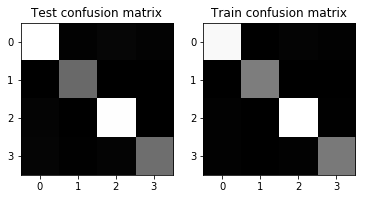

In [18]:
#Visualize confusion matrices

plt.subplot(121)
plt.imshow(conf_mx_test, cmap = plt.cm.gray)
plt.title("Test confusion matrix")

plt.subplot(122)
plt.imshow(conf_mx_train, cmap = plt.cm.gray)
plt.title("Train confusion matrix")

plt.show()
plt.close()

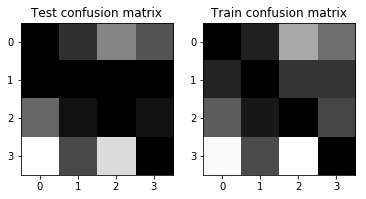

In [19]:
def plot_confusion_matrix_error(conf_mx):
    row_sums = conf_mx.sum(axis = 1, keepdims = True)
    norm_conf_mx = conf_mx / row_sums
    np.fill_diagonal(norm_conf_mx, 0)
    plt.imshow(norm_conf_mx, cmap = plt.cm.gray)

plt.subplot(121)
plot_confusion_matrix_error(conf_mx_test)
plt.title("Test confusion matrix")

plt.subplot(122)
plot_confusion_matrix_error(conf_mx_train)
plt.title("Train confusion matrix")

plt.show()

## "Playing" the product delivery game with the learnt policy

In [20]:
episode_length = 30
seed = 80
np.random.seed(seed)

system = PDSystemEnv(tank_max_loads = TANK_MAX_LOADS, level_percentages = LEVEL_PERCENTAGES,
                     truck_max_loads = TRUCK_MAX_LOADS, graph_weights = GRAPH_WEIGHTS,  
                     discrete = DISCRETE)
# ENSURE TO SET CASE = -1 (or another negative number) in the
# constants.py file

env = gym.make("PDSystemEnv-v0")
env._max_episode_steps = episode_length

In [21]:
frames = []
n_episodes = 9

# Output headers to file
with open(test_file,'w') as f:
     np.savetxt(f, [["step", "stock0", "stock1", "stock2"]], fmt="%s", delimiter=',')    


with tf.Session() as sess:
        sess.run(init)
        saver.restore(sess, model_file)
        for episode in range(n_episodes):
            state = env.reset()
            for step in range(episode_length):
                # Output data to files
                with open(test_file,'ab') as f:
                         np.savetxt(f, [[int(step)]+ state.tolist()] , fmt=('%d','%.6f','%.6f','%.6f'), delimiter=',')    
                    
                system.state = state
                img = system.visualize()
                frames.append(img)

                action_val = action.eval(feed_dict={X: state.reshape(1, n_inputs)})
 
                state, reward, done, info = env.step(action_val[0])
                #print(action_val[0],emptiest_tank_policy(state, system))
        
                if done:
                    break
        env.close()

INFO:tensorflow:Restoring parameters from ./simulations/simulation3/final_nn_classifier_sim3.ckpt


### Visualizing stocks during the test simulation

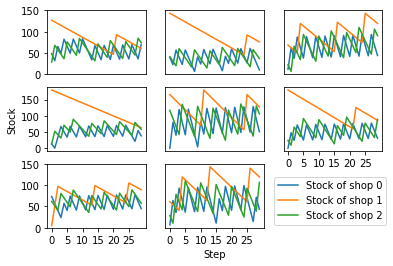

In [22]:
metrics = pd.read_table(test_file, sep = ",")

x= metrics['step']
for j in range(1,n_episodes):
    plt.subplot(3,3,j)

    for i in range(1,4):
        plt.plot(x[30*(j-1):30*j],metrics['stock{}'.format(i-1)][30*(j-1):30*j], 
                 label = 'Stock of shop {}'.format(i-1))
    
    if j >=6:
        plt.xticks(range(0,30,5))
    else:
        plt.xticks([])
    if j == 1 or j ==4 or j == 7:    
        plt.yticks([0,50,100,150])
    else:
        plt.yticks([])
        
    if j ==8:
        plt.xlabel("Step")
    if j ==4:
        plt.ylabel("Stock")

plt.legend(bbox_to_anchor=(1.1, 0.8), loc=2, borderaxespad=0.)

plt.subplots_adjust()
plt.show()
#plt.savefig('./../Images/test-stocks' + '.pdf')    
plt.close()

### Visualizing the performance of the policy


In [23]:
test_anim = ut.create_system_animation(frames, n_episodes * episode_length)
plt.close()

HTML(test_anim.to_html5_video())